# Data Ingestion

In [1]:
import torch
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('/data/KukaDirectDynamics.mat')

In [3]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


In [4]:
import numpy as np

trajectories = {}
total = 0
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
      print(f'{key} - {len(value)}')
      total += len(value)
      trajectories[key] = value

print(f'Total: {total}')

kukatraj1 - 1814
kukatraj10 - 1997
kukatraj2 - 1857
kukatraj3 - 1971
kukatraj4 - 1941
kukatraj5 - 1915
kukatraj6 - 2061
kukatraj7 - 1984
kukatraj8 - 2509
kukatraj9 - 2019
Total: 20068


In [ ]:
# KUKA LWR4+ dynamic parameters for each link
dynamic_params = [
    # Link 1
    {'mass': 4.1948, 'com': [0.0, 0.0, 0.0], 'inertia': [0.0019, 0.0, 0.0, 0.0, 0.0, 0.0]},
    # Link 2
    {'mass': 4.2997, 'com': [0.0003, -0.0041, 0.0824], 'inertia': [0.0474, 0.0500, 0.0016, -0.0000, 0.0001, -0.0009]},
    # Link 3
    {'mass': 3.6585, 'com': [0.0003, 0.1137, -0.0001], 'inertia': [0.0470, 0.0008, 0.0500, -0.0003, 0.0000, -0.0006]},
    # Link 4
    {'mass': 2.3847, 'com': [-0.0015, -0.0000, 0.1486], 'inertia': [0.0124, 0.0073, 0.0100, 0.0000, -0.0005, -0.0005]},
    # Link 5
    {'mass': 1.7036, 'com': [-0.0004, -0.0554, -0.0101], 'inertia': [0.0063, 0.0012, 0.0071, -0.0002, 0.0000, -0.0050]},
    # Link 6
    {'mass': 0.4001, 'com': [0.0021, 0.0586, -0.0448], 'inertia': [0.0005, 0.0000, 0.0035, 0.0000, -0.0000, -0.0011]},
    # Link 7
    {'mass': 0.6501, 'com': [-0.0005, 0.0015, 0.0716], 'inertia': [0.0000, 0.0000, 0.0001, -0.0000, 0.0000, 0.0000]}
]

In [ ]:
# Baxter dynamic parameters for each link
dynamic_params = [
    # Link 1: Upper Shoulder (S0)
    {'mass': 5.70044, 'com': [0.01783, 0.00086, 0.19127], 
     'inertia': [0.04709102262, 0.00012787556, 0.00614870039, 0.03766976455, 0.00078086899, 0.03595988478]},
    
    # Link 2: Lower Shoulder (S1)
    {'mass': 3.22698, 'com': [0.06845, 0.00269, -0.00529], 
     'inertia': [0.01175209419, -0.00030096398, 0.00207675762, 0.0278859752, -0.00018821993, 0.02078749298]},
    
    # Link 3: Upper Elbow (E0)
    {'mass': 4.31272, 'com': [-0.00276, 0.00132, 0.18086], 
     'inertia': [0.02661733557, 0.00029270634, 0.00392189887, 0.02844355207, 0.0010838933, 0.01248008322]},
    
    # Link 4: Lower Elbow (E1)
    {'mass': 2.07206, 'com': [0.02611, 0.00159, -0.01117], 
     'inertia': [0.00711582686, 0.00036036173, 0.0007459496, 0.01318227876, -0.00019663418, 0.00926852064]},
    
    # Link 5: Upper Forearm (W0)
    {'mass': 2.24665, 'com': [-0.00168, 0.0046, 0.13952], 
     'inertia': [0.01667742825, 0.00018403705, 0.00018657629, 0.01675457264, -0.00064732352, 0.0037463115]},
    
    # Link 6: Lower Forearm (W1)
    {'mass': 1.60979, 'com': [0.06041, 0.00697, 0.006], 
     'inertia': [0.00387607152, -0.00044384784, -0.00021115038, 0.00700537914, 0.00015348067, 0.0055275524]},
    
    # Link 7: Wrist (W2)
    {'mass': 0.35093, 'com': [0.00198, 0.00125, 0.01855], 
     'inertia': [0.00025289155, 0.00000575311, -0.00000159345, 0.0002688601, -0.00000519818, 0.0003074118]}
]


In [9]:
best_params = {'n_reservoir': 750,
    'spectral_radius': 0.9,
    'sparsity': 0.85,
    'leak_rate': 0.7000000000000001,
    'ghl_eta': 0.00012827395978719472,
    'ghl_decay_steps': 24000}

# In-depth Evaluation
---

In [ ]:
import torch
import sys
import utils
sys.path.append('models')

import pc_esn_model

trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

--- PC-ESN++ Evaluation Setup ---
Using device: cpu
Trajectories: 10
---------------------------------


In [ ]:
import time
from sklearn.preprocessing import StandardScaler
import numpy as np

traj = 10

overall_start_time = time.time()

fold_results = []
for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # 1. Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    # 2. Fit scalers
    x_scaler_fold = StandardScaler()

    X_train_scaled = x_scaler_fold.fit_transform(X_train)

    X_test_scaled = x_scaler_fold.transform(X_test)

    # 3. Convert to Tensors
    X_train_t = torch.from_numpy(X_train_scaled).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test_scaled).float().to(device)

    joint_positions = np.zeros(7)  # Assuming 7 joints

    # KUKA LWR4+ DH parameters
    dh_params = np.array([
        [  0,         0,      0.3105,  joint_positions[0]               ],
        [ -np.pi/2,   0,      0.0,     joint_positions[1] - np.pi/2     ],
        [  np.pi/2,   0,      0.4005,  joint_positions[2]               ],
        [  np.pi/2,   0,      0.0,     joint_positions[3] + np.pi/2     ],
        [ -np.pi/2,   0,      0.3900,  joint_positions[4]               ],
        [ -np.pi/2,   0,      0.0,     joint_positions[5] - np.pi/2     ],
        [  np.pi/2,   0,      0.0780,  joint_positions[6]               ]
    ])

    # Baxter DH parameters
    """dh_params = np.array([
        # α_{i−1},    a_{i−1},    d_i,        θ_i
        [  0,           0,          0.27035,    joint_positions[0]               ],
        [ -np.pi/2,     0.069,      0.0,        joint_positions[1] + np.pi/2     ],
        [  np.pi/2,     0,          0.36435,    joint_positions[2]               ],
        [ -np.pi/2,     0.069,      0.0,        joint_positions[3]               ],
        [  np.pi/2,     0.01,       0.37429,    joint_positions[4]               ],
        [ -np.pi/2,     0,          0.0,        joint_positions[5]               ],
        [  0,           0,          0.229525,   joint_positions[6]               ]
    ])"""

    # 4. Model Training (on scaled data)
    model = pc_esn_model.PC_ESN(n_inputs=21, n_outputs=14,
                   n_reservoir=best_params['n_reservoir'],
                   spectral_radius=best_params['spectral_radius'],
                   sparsity=best_params['sparsity'],
                   leak_rate=best_params['leak_rate'],
                   ghl_eta=best_params['ghl_eta'],
                   ghl_decay_steps=18000,
                   dh_params=dh_params,
                   dynamic_params=dynamic_params,
                   device=device)

    model.train(X_train_t, y_train_t)
    training_time = time.time() - fold_start_time

    y_pred_step, y_var_step = pc_esn_model.predict_step_by_step(X_test_t)
    y_pred_full, y_var_full = pc_esn_model.predict_full_trajectory(X_test_t)

    # 7. Calculate Metrics (on original scale data)
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test, y_pred_full)
    print(f"Step-by-Step Pos nMSE       | {np.mean(nmse_step[:7]):.4f}")
    print(f"Full Traj Pos nMSE          | {np.mean(nmse_full[:7]):.4f}")

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step),
        'full_op_space_error': np.mean(euclid_err_op_space_full),
        'true': y_test, 
        'step': y_pred_step, 'step_var': y_var_step,
        'full': y_pred_full, 'full_var': y_var_full
    }

    # Horizon Analysis (on original scale data)
    horizons = list(range(100, 1001, 100))
    for h in horizons:

        error_h = np.mean((y_test[:h] - y_pred_full[:h])**2, axis=0)
        variance_full = np.var(y_test, axis=0)
        variance_full[variance_full == 0] = 1 # Avoid division by zero
        nmse_h = error_h / variance_full


        euclid_h = utils.euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)

    fold_results.append(current_fold_results)
    traj -= 1
    print(f"Time to complete training: {(traj * (time.time()-fold_start_time))/60:.2f} minutes")


--- Fold 1/10 ---
Testing on: kukatraj1


/tmp/ipykernel_106/3015213950.py:203: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  var_i = (self.beta[i] / self.alpha[i]) * (1 + c_t.T @ self.V[i] @ c_t)


Step-by-Step Pos nMSE       | 0.7027
Full Traj Pos nMSE          | 1.5746
Time to complete training: 28.49 minutes

--- Fold 2/10 ---
Testing on: kukatraj10
Step-by-Step Pos nMSE       | 0.0614
Full Traj Pos nMSE          | 0.8187
Time to complete training: 24.85 minutes

--- Fold 3/10 ---
Testing on: kukatraj2
Step-by-Step Pos nMSE       | 0.4471
Full Traj Pos nMSE          | 1.5471
Time to complete training: 25.13 minutes

--- Fold 4/10 ---
Testing on: kukatraj3
Step-by-Step Pos nMSE       | 0.3594
Full Traj Pos nMSE          | 0.7332
Time to complete training: 19.87 minutes

--- Fold 5/10 ---
Testing on: kukatraj4
Step-by-Step Pos nMSE       | 0.2651
Full Traj Pos nMSE          | 1.1376
Time to complete training: 17.21 minutes

--- Fold 6/10 ---
Testing on: kukatraj5
Step-by-Step Pos nMSE       | 0.3658
Full Traj Pos nMSE          | 0.8456
Time to complete training: 13.22 minutes

--- Fold 7/10 ---
Testing on: kukatraj6
Step-by-Step Pos nMSE       | 0.4098
Full Traj Pos nMSE        

# Results
---

In [12]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.drop(['true', 'step', 'step_var', 'full','full_var'],axis=1).mean()
std_results = results_df.drop(['true', 'step', 'step_var', 'full','full_var'],axis=1).std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 34.19 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 189.84 ± 11.66
Step-by-Step Pos nMSE       | 0.3930 ± 0.2704
Step-by-Step Vel nMSE       | 0.5147 ± 0.2740
Step-by-Step Euclid Err (m) | 0.0983 ± 0.0877
Full Traj Pos nMSE          | 1.1929 ± 0.3487
Full Traj Vel nMSE          | 2.2965 ± 0.9638
Full Traj Euclid Err (m) | 0.1756 ± 0.0595
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 1.3334 ± 0.5633      | 0.1757 ± 0.1183
200     | 1.3424 ± 0.5948      | 0.1732 ± 0.1201
300     | 1.2681 ± 0.5432      | 0.1724 ± 0.0880
400     | 1.1074 ± 0.4403      | 0.1665 ± 0.0775
500     | 1.0370 ± 0

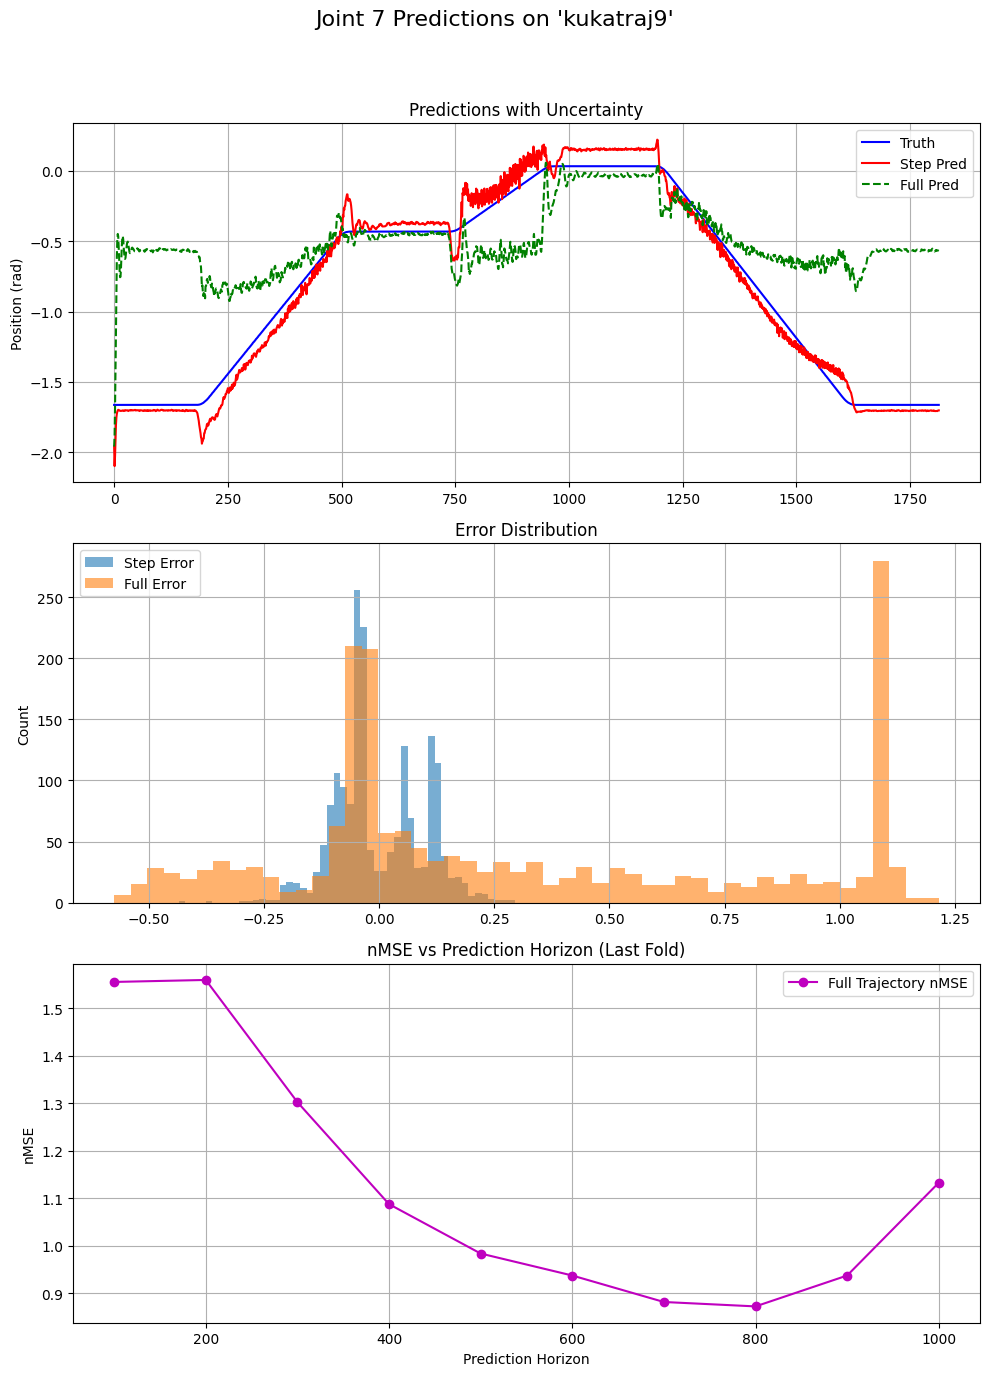

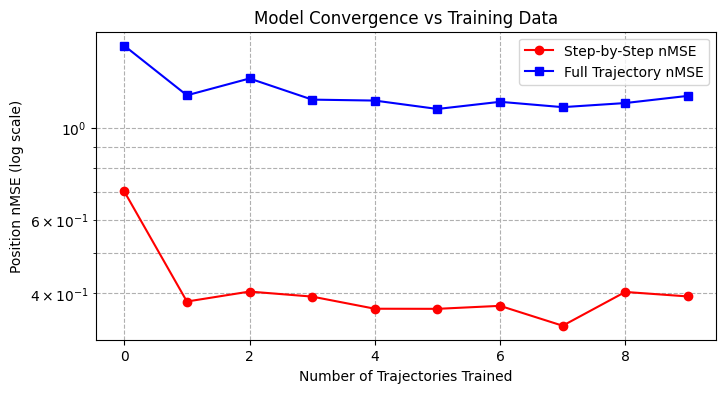

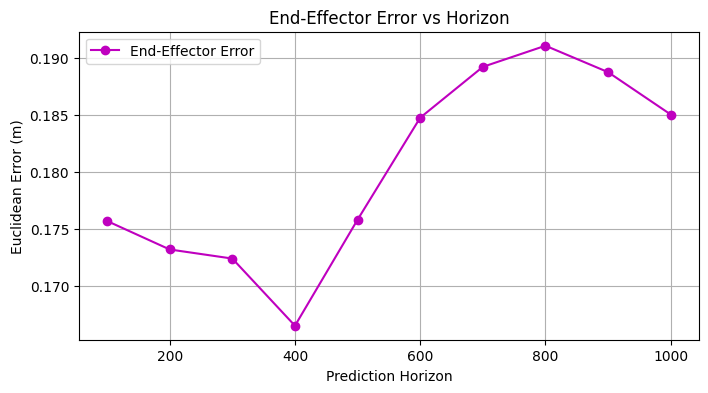

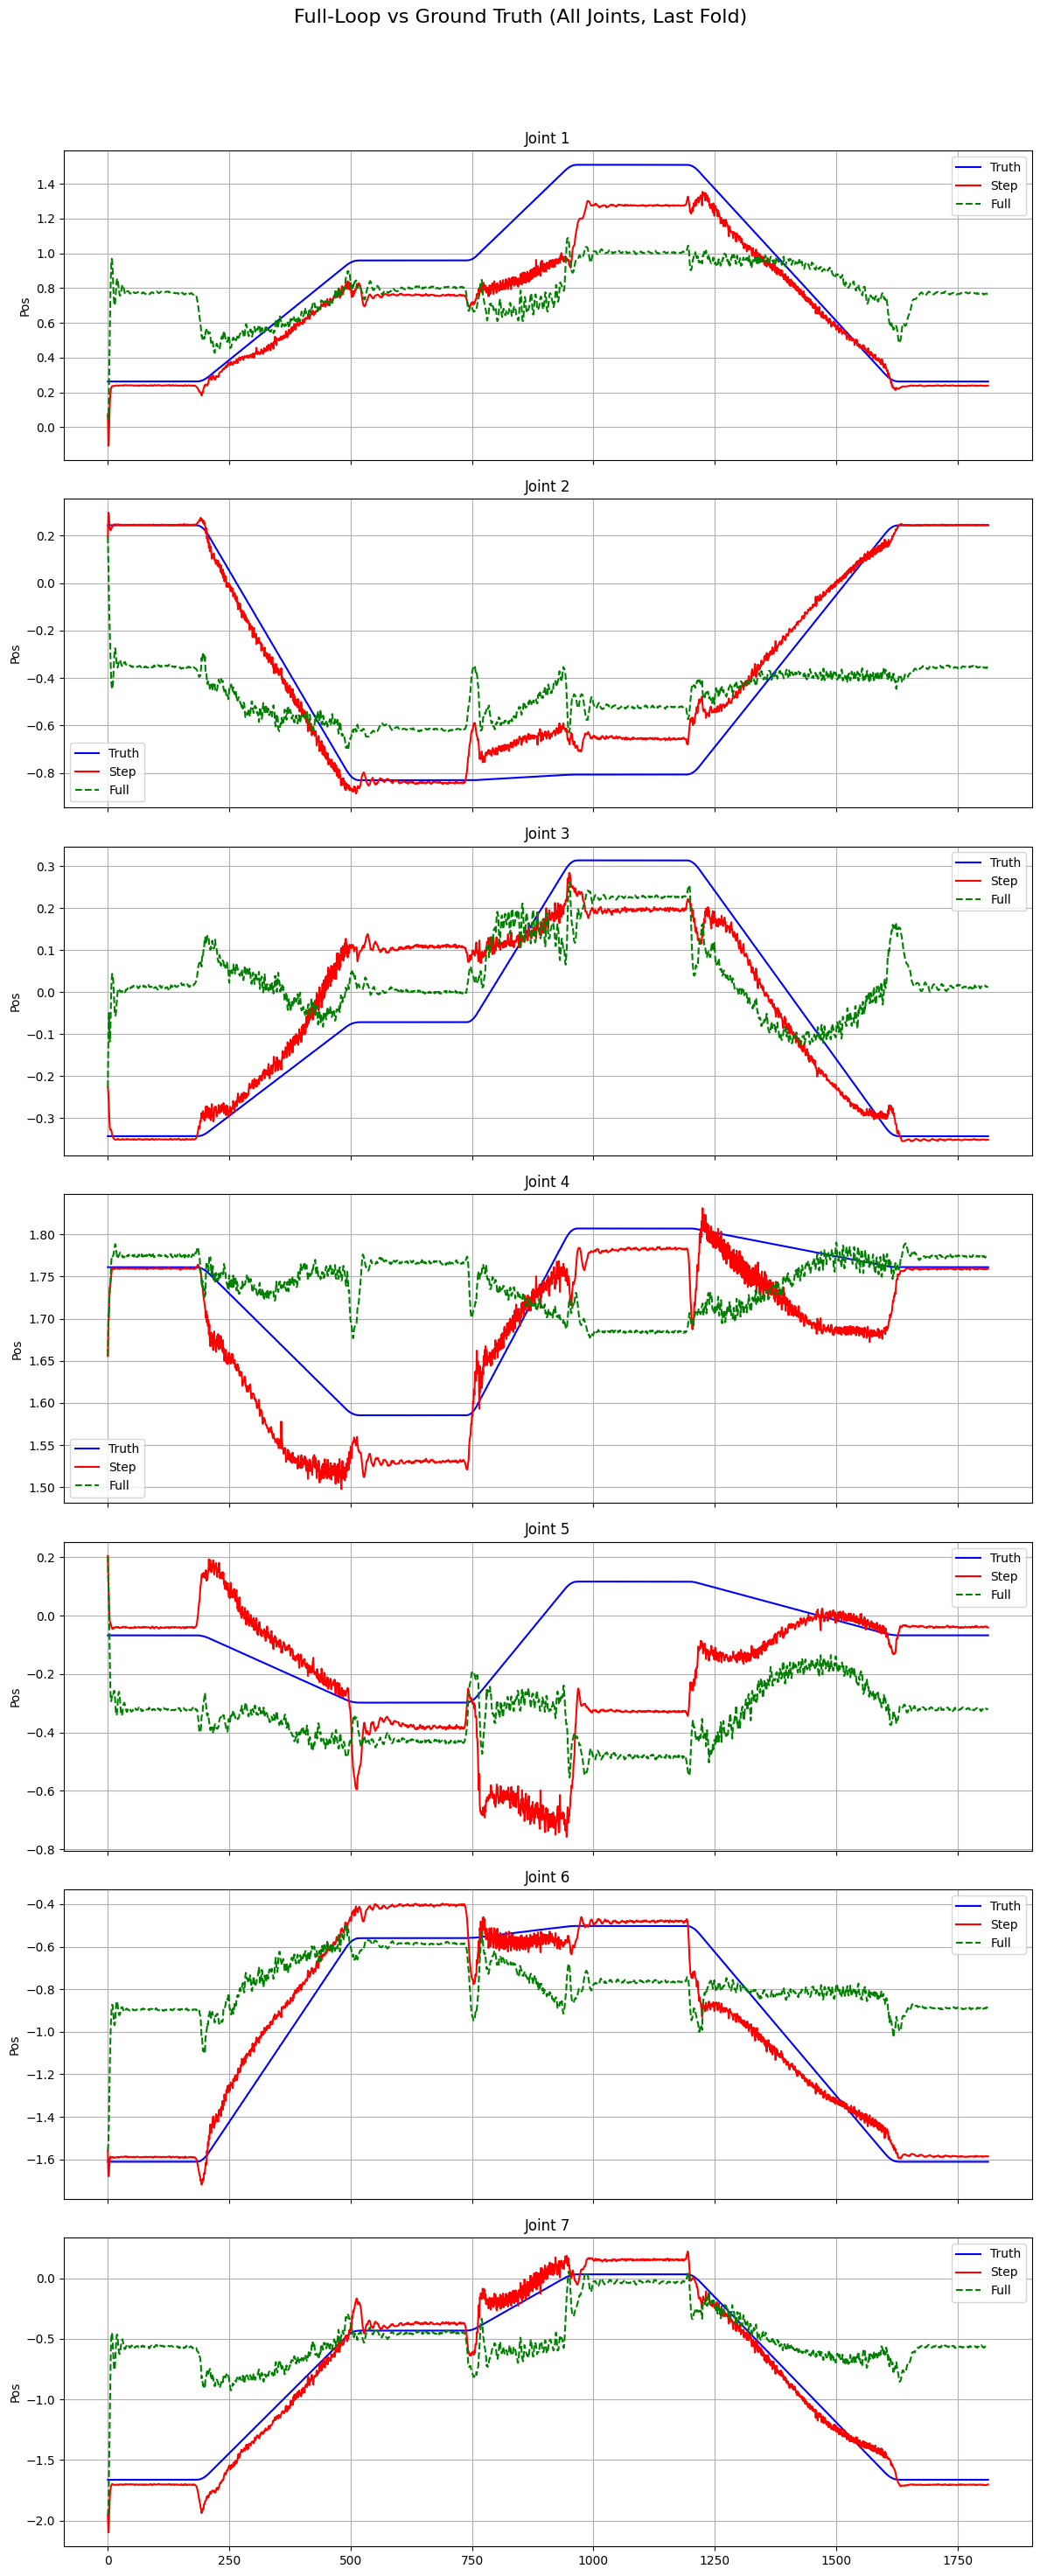

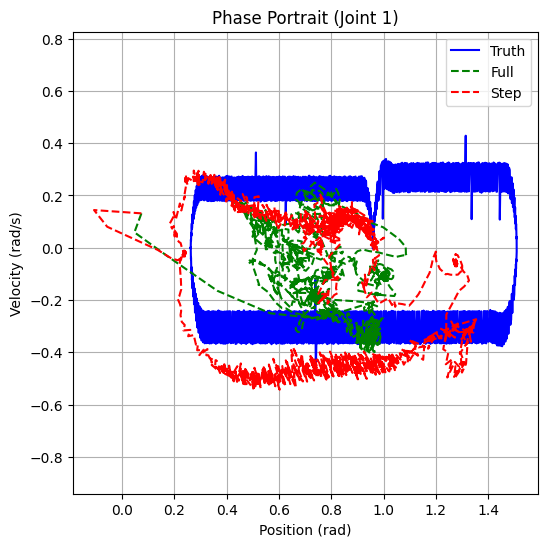

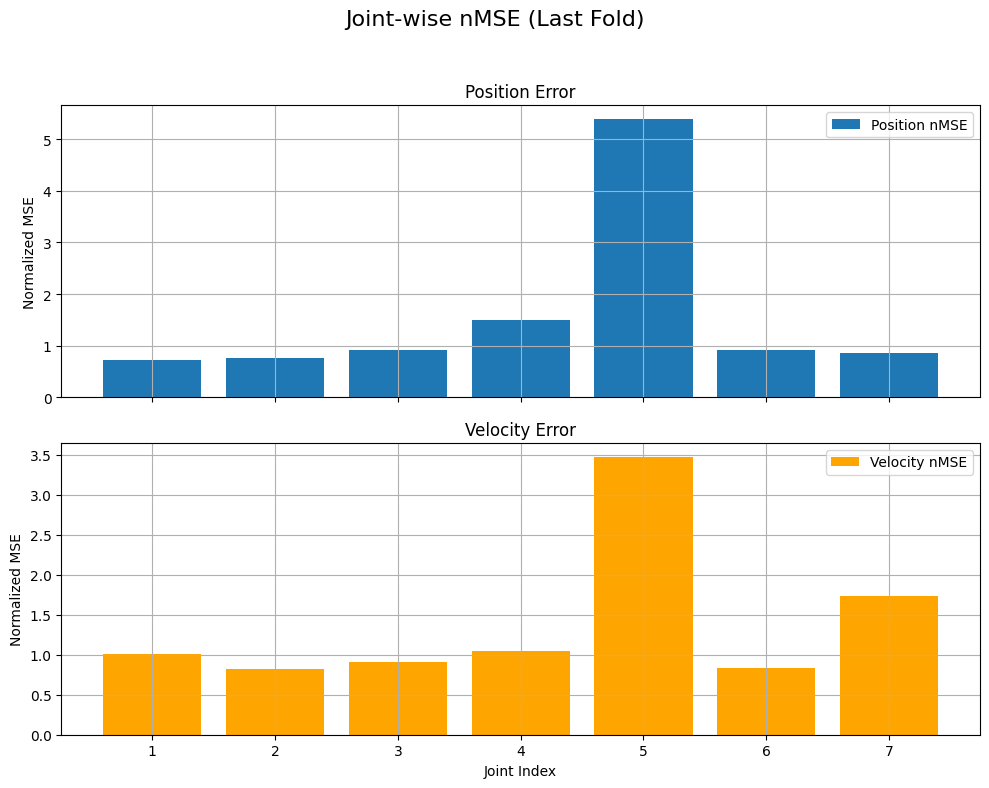

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
#  User-supplied data (assumed defined)
#    last_fold_preds: dict with keys 'true','step','full' as (T × J) arrays
#    results_df: pandas.DataFrame with fold-wise metrics
#    horizons: list of ints
#    test_key: str identifier for this trajectory
# ----------------------------------------

joint_to_plot = 6
y_true = results_df['true'][0][:, joint_to_plot]
y_step = results_df['step'][0][:, joint_to_plot]
y_full = results_df['full'][0][:, joint_to_plot]
#std_full = np.sqrt(last_fold_preds['full_var'][:, joint_to_plot])  # Standard deviation

# 1) Joint-specific overlay + error vs horizon
fig, axs = plt.subplots(3, 1, figsize=(10, 14))
fig.suptitle(f"Joint {joint_to_plot+1} Predictions on '{test_key}'", fontsize=16)

# Plot with uncertainty
axs[0].plot(y_true, 'b-', label='Truth')
axs[0].plot(y_step, 'r-', label='Step Pred')  # No variance for step unless computed
axs[0].plot(y_full, 'g--', label='Full Pred')
#axs[0].fill_between(range(len(y_full)), y_full - std_full, y_full + std_full, color='g', alpha=0.2)
axs[0].set_title('Predictions with Uncertainty')
axs[0].set_ylabel('Position (rad)')
axs[0].legend()
axs[0].grid(True)

# Error histogram
err_step = y_step - y_true
err_full = y_full - y_true
axs[1].hist(err_step, bins=50, alpha=0.6, label='Step Error')
axs[1].hist(err_full, bins=50, alpha=0.6, label='Full Error')
axs[1].set_title('Error Distribution')
axs[1].set_ylabel('Count')
axs[1].legend(); axs[1].grid(True)

# nMSE vs horizon (last fold)
h_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
nmse_vals = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in h_vals]
axs[2].plot(h_vals, nmse_vals, 'm-o', label='Full Trajectory nMSE')
axs[2].set_xlabel('Prediction Horizon')
axs[2].set_ylabel('nMSE')
axs[2].set_title('nMSE vs Prediction Horizon (Last Fold)')
axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])


# 2) Convergence plot (averaged over folds)
fig2, ax2 = plt.subplots(figsize=(8, 4))
n = len(results_df)
x = np.arange(1, n+1)
ax2.plot(results_df['sbs_pos_nmse'].expanding().mean(),
         'r-o', label='Step-by-Step nMSE')
ax2.plot(results_df['full_pos_nmse'].expanding().mean(),
         'b-s', label='Full Trajectory nMSE')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Trajectories Trained')
ax2.set_ylabel('Position nMSE (log scale)')
ax2.set_title('Model Convergence vs Training Data')
ax2.legend(); ax2.grid(True, which='both', ls='--')


# 3) Operational-space error vs horizon (averaged)
fig3, ax3 = plt.subplots(figsize=(8, 4))
horiz_cols = [f'full_euclid_err_h{h}' for h in horizons
              if f'full_euclid_err_h{h}' in results_df.columns]
mean_op_err = results_df[horiz_cols].mean().values
ax3.plot(horizons[:len(mean_op_err)], mean_op_err,
         'm-o', label='End-Effector Error')
ax3.set_xlabel('Prediction Horizon')
ax3.set_ylabel('Euclidean Error (m)')
ax3.set_title('End-Effector Error vs Horizon')
ax3.legend(); ax3.grid(True)


# 4) All 8 joints, full vs truth (last fold)
fig4, axs4 = plt.subplots(7, 1, figsize=(12, 30), sharex=True)
fig4.suptitle('Full-Loop vs Ground Truth (All Joints, Last Fold)', fontsize=16)
axs4 = axs4.ravel()
n_joints = 7
for j in range(n_joints):
    axs4[j].plot(results_df['true'][0][:, j], 'b-')
    axs4[j].plot(results_df['step'][0][:, j], 'r-')
    axs4[j].plot(results_df['full'][0][:, j], 'g--')
    axs4[j].set_title(f'Joint {j+1}')
    axs4[j].set_ylabel('Pos'); axs4[j].legend(['Truth','Step','Full']); axs4[j].grid(True)
# hide extra subplot if 8<9
if len(axs4) > n_joints:
    axs4[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])


# 5) Phase portrait for a sample joint
fig5, ax5 = plt.subplots(figsize=(6, 6))
j0 = 0
pos = results_df['true'][0][:, j0]
vel = results_df['true'][0][:, j0+7]  # assumes 8 pos + 8 vel
ax5.plot(pos, vel,  'b-', label='Truth')
ax5.plot(results_df['full'][0][:, j0],
         results_df['full'][0][:, j0+7],
         'g--', label='Full')
ax5.plot(results_df['step'][0][:, j0],
         results_df['step'][0][:, j0+7],
         'r--', label='Step')
ax5.set_xlabel('Position (rad)')
ax5.set_ylabel('Velocity (rad/s)')
ax5.set_title(f'Phase Portrait (Joint {j0+1})')
ax5.legend(); ax5.grid(True); ax5.axis('equal')

# 6) Joint-wise nMSE bar chart
true_all = results_df['true'][0]
full_all = results_df['full'][0]
var_per_joint = true_all.var(axis=0)
var_per_joint[var_per_joint == 0] = 1 # Avoid division by zero
nmse_full = ((full_all - true_all)**2).mean(axis=0) / var_per_joint

# Separate nMSE for position (first 7 values) and velocity (last 7 values)
nmse_pos = nmse_full[:7]
nmse_vel = nmse_full[7:]
joint_indices = np.arange(1, 8)

# Create a figure with two subplots
fig6, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig6.suptitle('Joint-wise nMSE (Last Fold)', fontsize=16)

# Position nMSE plot
ax_pos.bar(joint_indices, nmse_pos, label='Position nMSE')
ax_pos.set_ylabel('Normalized MSE')
ax_pos.set_title('Position Error')
ax_pos.legend(); ax_pos.grid(True)

# Velocity nMSE plot
ax_vel.bar(joint_indices, nmse_vel, color='orange', label='Velocity nMSE')
ax_vel.set_xlabel('Joint Index')
ax_vel.set_ylabel('Normalized MSE')
ax_vel.set_title('Velocity Error')
ax_vel.set_xticks(joint_indices)
ax_vel.legend(); ax_vel.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])